In [1]:
!pip install sentence-transformers numpy pandas scipy datasets torch tensorflow


In [3]:
!pip install tf-keras


In [9]:
!pip install tensorflow-hub


In [20]:
!pip install matplotlib

In [21]:
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
import tensorflow_hub as hub
import time
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from datasets import load_dataset
import psutil
import os
import matplotlib.pyplot as plt


In [5]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
# Load a benchmark dataset for sentence similarity (STS-Benchmark)
dataset = load_dataset("stsb_multi_mt", name="en", split="test")
sentences1 = dataset["sentence1"][:100]  # Using first 100 pairs
sentences2 = dataset["sentence2"][:100]
ground_truth = dataset["similarity_score"][:100]

# Define pre-trained models for sentence similarity
models = {
    "SBERT": "sentence-transformers/all-MiniLM-L6-v2",
    "USE": "https://tfhub.dev/google/universal-sentence-encoder/4",
    "DistilBERT": "sentence-transformers/distilbert-base-nli-stsb-mean-tokens",
    "MPNet": "sentence-transformers/all-mpnet-base-v2"
}

# Dictionary to store results
results = {}

c:\AARUSH\COLLEGE\Semester 6\Predictive Analytics\Lab\LabAssignment3\venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aarush\.cache\huggingface\hub\datasets--stsb_multi_mt. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating dev split: 100%|██████████| 1500/1500 [00:00<?, ? examples/s]


In [7]:
# Function to measure memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Convert bytes to MB


In [11]:
# Evaluate each model
for model_name, model_path in models.items():
    print(f"Evaluating {model_name}...")

    start_time = time.time()

    # Load model
    if "USE" in model_name:
        # Use tensorflow_hub to load the USE model
        embedder = hub.load(model_path)
        encode_fn = lambda sentences: embedder(sentences).numpy()
    else:
        embedder = SentenceTransformer(model_path).to(device)
        encode_fn = lambda sentences: embedder.encode(sentences, convert_to_numpy=True)

    # Compute embeddings
    embeddings1 = encode_fn(sentences1)
    embeddings2 = encode_fn(sentences2)

    # Compute cosine similarity
    cosine_scores = [cosine_similarity([emb1], [emb2])[0][0] for emb1, emb2 in zip(embeddings1, embeddings2)]

    # Compute Spearman correlation with ground truth scores
    spearman_corr, _ = spearmanr(ground_truth, cosine_scores)

    # Measure inference time (ms)
    inference_time = (time.time() - start_time) * 1000 / len(sentences1)

    # Get model size (approximate size in MB)
    model_size = sum(p.numel() * p.element_size() for p in embedder.parameters()) / (1024 ** 2) if "USE" not in model_name else 300  # Approximate size for USE

    # Measure memory usage
    memory_usage = get_memory_usage()

    # Store results
    results[model_name] = [np.mean(cosine_scores), spearman_corr, inference_time, model_size, memory_usage]


Evaluating SBERT...
Evaluating USE...



Evaluating DistilBERT...


c:\AARUSH\COLLEGE\Semester 6\Predictive Analytics\Lab\LabAssignment3\venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aarush\.cache\huggingface\hub\models--sentence-transformers--distilbert-base-nli-stsb-mean-tokens. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Evaluating MPNet...


c:\AARUSH\COLLEGE\Semester 6\Predictive Analytics\Lab\LabAssignment3\venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aarush\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [12]:
# Convert results to DataFrame
df = pd.DataFrame.from_dict(results, orient="index", columns=[
    "Cosine_Similarity", "Spearman_Correlation", "Inference_Time", "Model_Size", "Memory_Usage"
])
print("\nOriginal Decision Matrix:")
display(df)


Original Decision Matrix:


,Cosine_Similarity,Spearman_Correlation,Inference_Time,Model_Size,Memory_Usage
SBERT,0.557192,0.933631,46.094351,86.644043,794.062500
USE,0.599967,0.874986,2649.962127,300.000000,2221.523438
DistilBERT,0.502379,0.907169,713.329036,253.154297,2364.664062
MPNet,0.522501,0.945303,1117.269466,417.657715,2701.457031


In [13]:
# Normalize the Decision Matrix
df_normalized = df.copy()

# Define benefit and cost criteria
benefit_cols = ["Cosine_Similarity", "Spearman_Correlation"]
cost_cols = ["Inference_Time", "Model_Size", "Memory_Usage"]

# Normalize benefit criteria
for col in benefit_cols:
    df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Normalize cost criteria (inverted normalization)
for col in cost_cols:
    df_normalized[col] = (df[col].max() - df[col]) / (df[col].max() - df[col].min())

print("\nNormalized Decision Matrix:")
display(df_normalized)


Normalized Decision Matrix:


,Cosine_Similarity,Spearman_Correlation,Inference_Time,Model_Size,Memory_Usage
SBERT,0.561676,0.834002,1.000000,1.000000,1.000000
USE,1.000000,0.000000,0.000000,0.355447,0.251617
DistilBERT,0.000000,0.457689,0.743752,0.496969,0.176572
MPNet,0.206202,1.000000,0.588622,0.000000,0.000000


In [14]:
# Assign Weights to Each Criterion
weights = {
    "Cosine_Similarity": 0.35,
    "Spearman_Correlation": 0.25,
    "Inference_Time": 0.15,
    "Model_Size": 0.15,
    "Memory_Usage": 0.10
}

# Multiply the normalized values by their corresponding weights
for col, weight in weights.items():
    df_normalized[col] *= weight

print("\nWeighted Normalized Decision Matrix:")
display(df_normalized)


Weighted Normalized Decision Matrix:


,Cosine_Similarity,Spearman_Correlation,Inference_Time,Model_Size,Memory_Usage
SBERT,0.196587,0.208501,0.150000,0.150000,0.100000
USE,0.350000,0.000000,0.000000,0.053317,0.025162
DistilBERT,0.000000,0.114422,0.111563,0.074545,0.017657
MPNet,0.072171,0.250000,0.088293,0.000000,0.000000


In [15]:
# Determine Ideal (Best) and Negative-Ideal (Worst) Solutions
ideal_solution = df_normalized.max()
negative_ideal_solution = df_normalized.min()

print("\nIdeal (Best) Solution:")
display(ideal_solution)

print("\nNegative-Ideal (Worst) Solution:")
display(negative_ideal_solution)



Ideal (Best) Solution:


Cosine_Similarity       0.35
Spearman_Correlation    0.25
Inference_Time          0.15
Model_Size              0.15
Memory_Usage            0.10
dtype: float64


Negative-Ideal (Worst) Solution:


Cosine_Similarity       0.0
Spearman_Correlation    0.0
Inference_Time          0.0
Model_Size              0.0
Memory_Usage            0.0
dtype: float64

In [16]:
# Compute Euclidean Distances to Ideal and Negative-Ideal Solutions
def euclidean_distance(row, target):
    return np.sqrt(((row - target) ** 2).sum())

# Compute distances
distances = pd.DataFrame(index=df_normalized.index, columns=["Distance_to_Ideal", "Distance_to_Negative"])

for model in df_normalized.index:
    distances.loc[model, "Distance_to_Ideal"] = euclidean_distance(df_normalized.loc[model], ideal_solution)
    distances.loc[model, "Distance_to_Negative"] = euclidean_distance(df_normalized.loc[model], negative_ideal_solution)

print("\nSeparation Measures:")
display(distances)


Separation Measures:


,Distance_to_Ideal,Distance_to_Negative
SBERT,0.158927,0.370296
USE,0.316146,0.354931
DistilBERT,0.393488,0.177222
MPNet,0.336893,0.27478


In [17]:
# Compute TOPSIS Score and Rank Models
distances["TOPSIS_Score"] = distances["Distance_to_Negative"] / (distances["Distance_to_Ideal"] + distances["Distance_to_Negative"])
distances["Rank"] = distances["TOPSIS_Score"].rank(ascending=False)

print("\nFinal TOPSIS Scores and Ranking:")
display(distances.sort_values("Rank"))


Final TOPSIS Scores and Ranking:


,Distance_to_Ideal,Distance_to_Negative,TOPSIS_Score,Rank
SBERT,0.158927,0.370296,0.699697,1.0
USE,0.316146,0.354931,0.528897,2.0
MPNet,0.336893,0.27478,0.449227,3.0
DistilBERT,0.393488,0.177222,0.310529,4.0


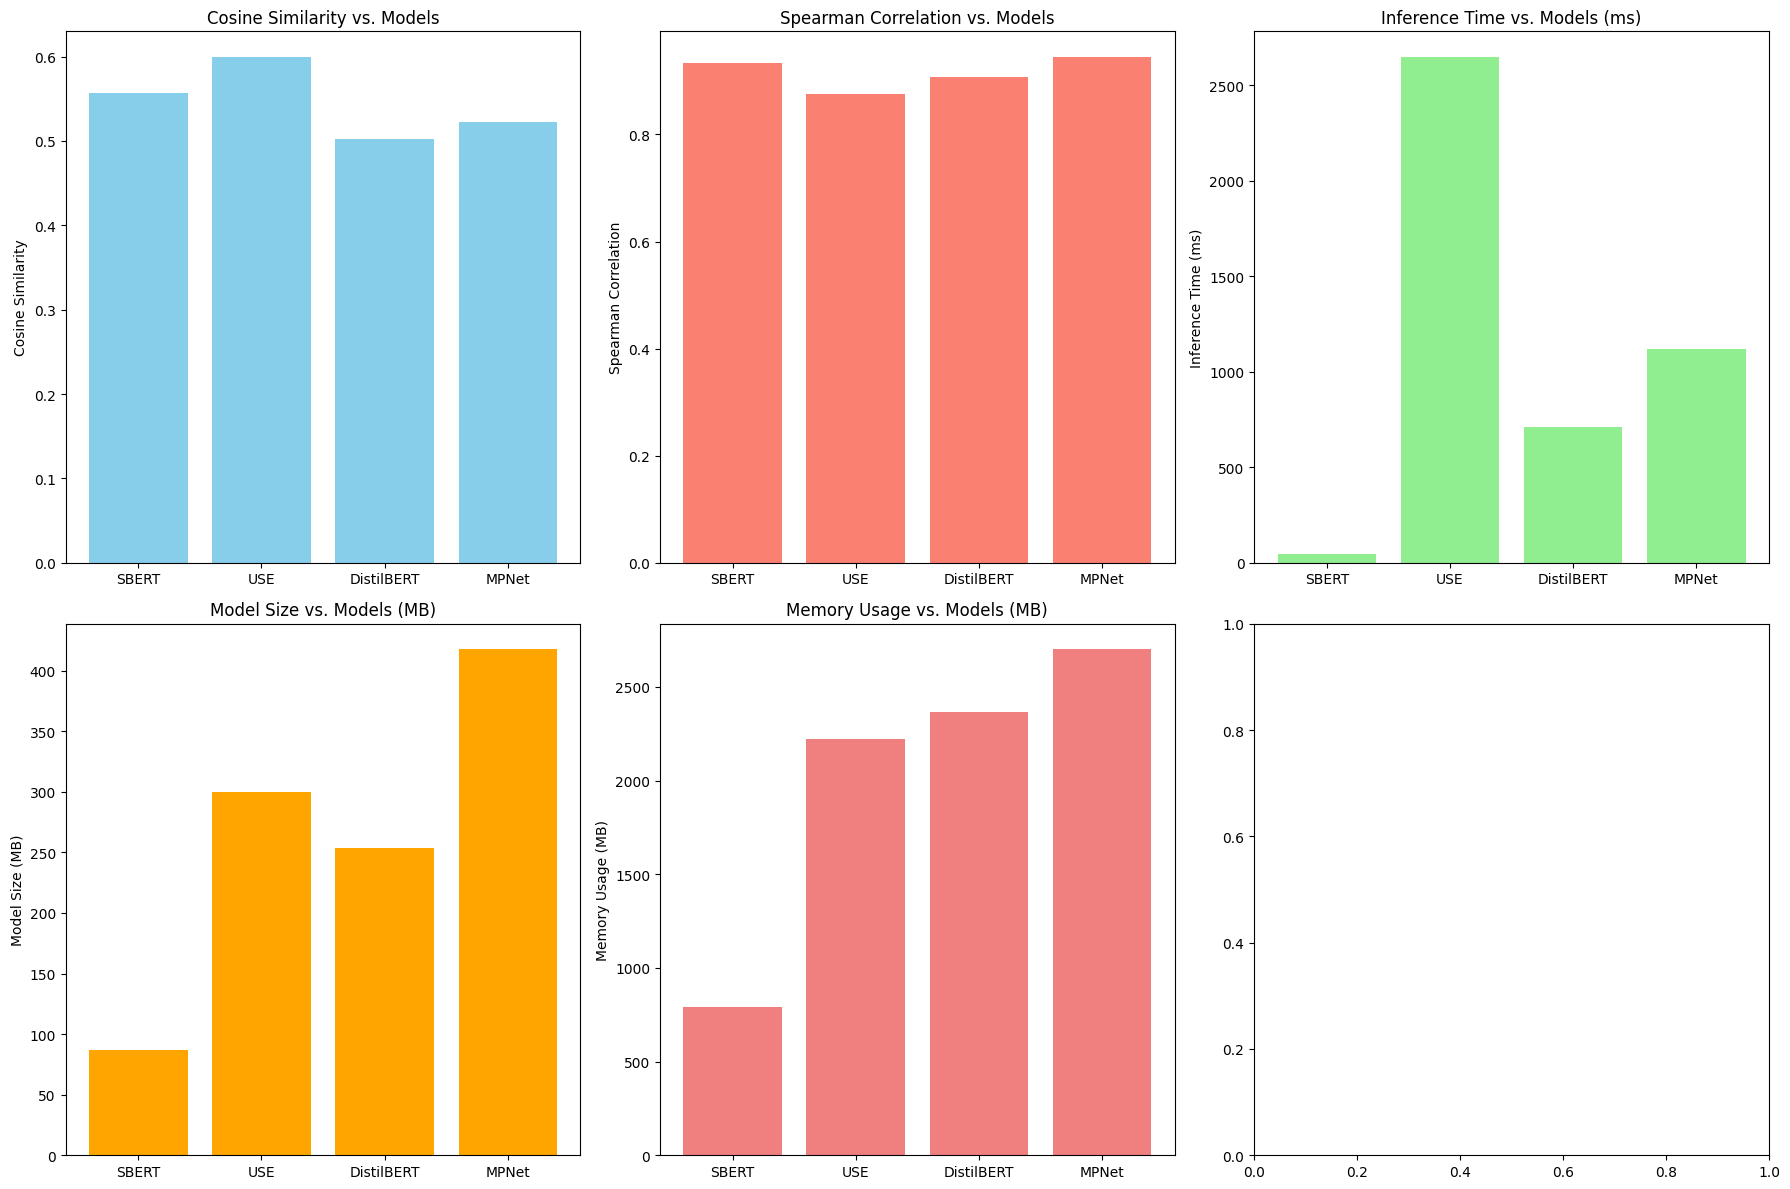

In [23]:
# Plotting the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Cosine Similarity vs. Models
axes[0, 0].bar(df.index, df["Cosine_Similarity"], color='skyblue')
axes[0, 0].set_title("Cosine Similarity vs. Models")
axes[0, 0].set_ylabel("Cosine Similarity")

# Spearman Correlation vs. Models
axes[0, 1].bar(df.index, df["Spearman_Correlation"], color='salmon')
axes[0, 1].set_title("Spearman Correlation vs. Models")
axes[0, 1].set_ylabel("Spearman Correlation")

# Inference Time vs. Models
axes[0, 2].bar(df.index, df["Inference_Time"], color='lightgreen')
axes[0, 2].set_title("Inference Time vs. Models (ms)")
axes[0, 2].set_ylabel("Inference Time (ms)")

# Model Size vs. Models
axes[1, 0].bar(df.index, df["Model_Size"], color='orange')
axes[1, 0].set_title("Model Size vs. Models (MB)")
axes[1, 0].set_ylabel("Model Size (MB)")

# Memory Usage vs. Models
axes[1, 1].bar(df.index, df["Memory_Usage"], color='lightcoral')
axes[1, 1].set_title("Memory Usage vs. Models (MB)")
axes[1, 1].set_ylabel("Memory Usage (MB)")


# Adjust layout and show the plots
plt.tight_layout()
plt.show()